# Import necessary libraries

In [17]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as r 

from collections import defaultdict, deque
from dataclasses import dataclass, field
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import KernelPCA

# Code to combine datasets from multiple seasons

In [18]:
#Find the common columns between 2021-11.csv and 2021-2022.csv
cols1 = set(pd.read_csv("Datasets/2009-10.csv", nrows=0).columns)
cols2 = set(pd.read_csv("Datasets/2021-2022.csv", nrows=0).columns)
common_cols = sorted(cols1 & cols2)

print(f"Using {len(common_cols)} common columns:\n{common_cols}\n")

list_of_files = [
    "Datasets/2009-10.csv",
    "Datasets/2010-11.csv",
    "Datasets/2011-12.csv",
    "Datasets/2012-13.csv",
    "Datasets/2013-14.csv",
    "Datasets/2014-15.csv",
    "Datasets/2015-16.csv",
    "Datasets/2016-17.csv",
    "Datasets/2017-18.csv",
    "Datasets/2018-19.csv",
    "Datasets/2019-20.csv",
    "Datasets/2020-2021.csv",
    "Datasets/2021-2022.csv",
]


dfs = []
for fname in list_of_files:
    if not os.path.isfile(fname):
        print(f"{fname} not found, skipping")
        continue

    df = pd.read_csv(fname)
    df = df.reindex(columns=common_cols)  # drops extras columns
    dfs.append(df)

#Concatenate and save
combined = pd.concat(dfs, ignore_index=True)
combined.to_csv("datacombined.csv", index=False)

print(f"Wrote all_seasons_common_cols.csv "
      f"({combined.shape[0]} rows × {combined.shape[1]} cols)")


Using 38 common columns:
['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'Referee', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH']

Wrote all_seasons_common_cols.csv (4600 rows × 38 cols)


# Code to create new features from existing features

In [19]:
h2h_past3 = defaultdict(lambda: deque(maxlen=3))
h2h_past5 = defaultdict(lambda: deque(maxlen=5))

class StandingsEntry:
    def __init__(self, team_name: str):
        self.team_name = team_name
        self.points    = 0
        self.standing  = 0

class Teamstats:
    def __init__(self, team_name, past_standing = 21):
        self.team_name = team_name
         # Rolling windows for form
        self.last5 = deque(maxlen=5)
        self.last3 = deque(maxlen=3)
         # Streak & points
        self.streak = 0
        self.streak_type = 0  # 1 for win, -1 for loss, 0 for draw
        self.current_points = 0
         # Season totals
        self.games_played = 0
        self.total_goals = 0
        self.total_shots = 0
        self.total_shots_on_target = 0
        self.total_corners = 0
        self.total_fouls = 0
        # Opponent stats
        self.total_goals_against = 0
        self.total_shots_against = 0
        self.total_shots_on_target_against = 0
        self.total_corners_against = 0
        self.total_fouls_against = 0
        # Last two cards
        self.reds_last_two = deque(maxlen=2)
        self.yellows_last_two = deque(maxlen=2)
        # Past season finish 
        self.past_standing = past_standing
       
        
    def new_season(self):
        # cards and points
        self.reds_last_two.clear()
        self.yellows_last_two.clear()
        self.current_points = 0
        # season totals
        self.games_played = 0
        self.total_goals = 0
        self.total_goals_against = 0
        self.total_shots = 0
        self.total_shots_on_target = 0
        self.total_corners = 0
        self.total_fouls = 0 
        # opponent stats
        self.total_goals_against = 0
        self.total_shots_against = 0
        self.total_shots_on_target_against = 0
        self.total_corners_against = 0
        self.total_fouls_against = 0
        # past season finish
        pass
    
    def get_streak(self, result):    
        if result == self.streak_type:
            self.streak += result
        else:
            self.streak = result
            self.streak_type = result
            
    def get_points(self, result):
        if result == 1:
            self.current_points += 3
        elif result == 0:
            self.current_points += 1
    
    def add_game(
        self,goals_for,goals_against,shots_for,shots_against,sot_for,sot_against,corners_for,corners_against,fouls_for,fouls_against,reds,yellows,result):
        # Totals for and against
        self.total_goals           += goals_for
        self.total_goals_against   += goals_against
        self.total_shots           += shots_for
        self.total_shots_against   += shots_against
        self.total_shots_on_target += sot_for
        self.total_shots_on_target_against += sot_against
        self.total_corners         += corners_for
        self.total_corners_against += corners_against
        self.total_fouls           += fouls_for
        self.total_fouls_against   += fouls_against
        # Cards
        self.reds_last_two.append(reds)
        self.yellows_last_two.append(yellows)
        # Games and form deques
        self.games_played += 1
        self.last5.append(result)
        self.last3.append(result)
        # Streak and points
        self.get_streak(result)
        self.get_points(result)
        
    @property
    def past3_form(self):
        return sum(self.last3)

    @property
    def past5_form(self):
        return sum(self.last5)

    @property
    def current_streak(self):
        return self.streak

    @property
    def goals_per_game(self):
        return round(self.total_goals / self.games_played, 2) if self.games_played else 0

    @property
    def shots_per_game(self):
        return round(self.total_shots / self.games_played, 2) if self.games_played else 0

    @property
    def shots_on_target_per_game(self):
        return round(self.total_shots_on_target / self.games_played, 2) if self.games_played else 0

    @property
    def corners_per_game(self):
        return round(self.total_corners / self.games_played, 2) if self.games_played else 0

    @property
    def fouls_per_game(self):
        return round(self.total_fouls / self.games_played, 2) if self.games_played else 0

    @property
    def goals_against_per_game(self):
        return round(self.total_goals_against / self.games_played, 2) if self.games_played else 0

    @property
    def shots_against_per_game(self):
        return round(self.total_shots_against / self.games_played, 2) if self.games_played else 0

    @property
    def shots_on_target_against_per_game(self):
        return round(self.total_shots_on_target_against / self.games_played, 2) if self.games_played else 0

    @property
    def corners_against_per_game(self):
        return round(self.total_corners_against / self.games_played, 2) if self.games_played else 0

    @property
    def fouls_against_per_game(self):
        return round(self.total_fouls_against / self.games_played, 2) if self.games_played else 0

    @property
    def reds_last2(self):
        return sum(self.reds_last_two)

    @property
    def yellows_last2(self):
        return sum(self.yellows_last_two)

team_dict = {}
standings_dict = {}
    
def load_past_standings(path):
    df = pd.read_csv(path)
    # if the "2008" column has NaNs, replace them with 0 and cast to int
    df['2009'] = df['2009'].fillna(0).astype(int)

    for _, row in df.iterrows():
        pos = row['2009'] 
        if pos <= 17 and pos != 0:
            team = Teamstats(row['Team'], pos)
            team_dict[row['Team']] = team
    
def update_standings_dict(home, away, home_points, away_points):
    if home not in standings_dict:
        standings_dict[home] = StandingsEntry(home)
    standings_dict[home].points += home_points
    
    if away not in standings_dict:
        standings_dict[away] = StandingsEntry(away)
    standings_dict[away].points += away_points
    get_ranking()
    
def get_ranking():
    # Sort the standings dictionary by points and update the standing attribute for each team
    sorted_standings = sorted(standings_dict.items(),key=lambda item: item[1].points,reverse=True)
    for rank, (team_name, stats) in enumerate(sorted_standings, start=1):
        stats.standing = rank

def new_season_check(month, prevmonth):
    return month >= 8 and prevmonth <= 6

def new_season_standings():
    get_ranking()
    for team_name, entry in standings_dict.items():
        if entry.standing <= 17:
            team_dict[team_name].past_standing = entry.standing
    standings_dict.clear()

# Load the CSV into a DataFrame
def main():
    '''corresponding game # (so its 1 to 1 with from09_sorted.csv), and then the following features for both away and home: the past 3 game form (increment vs decrement),
    past 5 game form (same thing), h2h past 5, h2h past 3, streak (increment or decrement until steak ends then becomes 1 or -1), current standing (win = +3, draw = +1, lose = 0), past season standing  (21 if NaN),  
    goals per game (total goals/games player per season), shots on target per game (same thing), shots per page (same thing), corners per game (same thing), fouls per game (same thing), 
    reds last two games , yellows last two games.'''        
    df = pd.read_csv('datacombined.csv')
    load_past_standings('EPLStandings.csv')

    standings_dict.clear()
    prevmonth = None
    features_list = []
    features_list20 = [] # for 20+ games

    for idx, row in df.iterrows():
        date = pd.to_datetime(row['Date'], dayfirst=True, yearfirst=False, errors='coerce')
        month = date.month

        if prevmonth and new_season_check(month, prevmonth):
            new_season_standings()
            for team in team_dict.values():
                team.new_season()

        prevmonth = month

        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        for team_name in [home_team, away_team]:
            if team_name not in team_dict:
                team_dict[team_name] = Teamstats(team_name)
            if team_name not in standings_dict:
                standings_dict[team_name] = StandingsEntry(team_name)

        home_goals = row['FTHG']
        away_goals = row['FTAG']
        result_home = 1 if home_goals > away_goals else -1 if home_goals < away_goals else 0
        result_away = -result_home

        home_points = 3 if result_home == 1 else 1 if result_home == 0 else 0
        away_points = 3 if result_away == 1 else 1 if result_away == 0 else 0
        
        home_h2h3 = sum(h2h_past3[(home_team, away_team)])
        home_h2h5 = sum(h2h_past5[(home_team, away_team)])
        away_h2h3 = sum(h2h_past3[(away_team, home_team)])
        away_h2h5 = sum(h2h_past5[(away_team, home_team)])
    
        # Build features row before updating stats
        features_row = {
            # Home team features
            'Home_Past3_Form': team_dict[home_team].past3_form,
            'Home_Past5_Form': team_dict[home_team].past5_form,
            'Home_Streak': team_dict[home_team].current_streak,
            'Home_Current_Standing': standings_dict[home_team].standing,
            'Home_Past_Standing': team_dict[home_team].past_standing,
            'Home_Goals_Per_Game': team_dict[home_team].goals_per_game,
            'Home_Shots_Per_Game': team_dict[home_team].shots_per_game,
            'Home_SOT_Per_Game': team_dict[home_team].shots_on_target_per_game,
            'Home_Corners_Per_Game': team_dict[home_team].corners_per_game,
            'Home_Fouls_Per_Game': team_dict[home_team].fouls_per_game,
            'Home_Reds_Last2': team_dict[home_team].reds_last2,
            'Home_Yellows_Last2': team_dict[home_team].yellows_last2,
            'Home_Goals_Against_Per_Game': team_dict[home_team].goals_against_per_game,
            'Home_Shots_Against_Per_Game': team_dict[home_team].shots_against_per_game,
            'Home_SOT_Against_Per_Game': team_dict[home_team].shots_on_target_against_per_game,
            'Home_Corners_Against_Per_Game': team_dict[home_team].corners_against_per_game,
            'Home_Fouls_Against_Per_Game': team_dict[home_team].fouls_against_per_game,

            # Away team features
            'Away_Past3_Form': team_dict[away_team].past3_form,
            'Away_Past5_Form': team_dict[away_team].past5_form,
            'Away_Streak': team_dict[away_team].current_streak,
            'Away_Current_Standing': standings_dict[away_team].standing,
            'Away_Past_Standing': team_dict[away_team].past_standing,
            'Away_Goals_Per_Game': team_dict[away_team].goals_per_game,
            'Away_Shots_Per_Game': team_dict[away_team].shots_per_game,
            'Away_SOT_Per_Game': team_dict[away_team].shots_on_target_per_game,
            'Away_Corners_Per_Game': team_dict[away_team].corners_per_game,
            'Away_Fouls_Per_Game': team_dict[away_team].fouls_per_game,
            'Away_Goals_Against_Per_Game': team_dict[away_team].goals_against_per_game,
            'Away_Shots_Against_Per_Game': team_dict[away_team].shots_against_per_game,
            'Away_SOT_Against_Per_Game': team_dict[away_team].shots_on_target_against_per_game,
            'Away_Corners_Against_Per_Game': team_dict[away_team].corners_against_per_game,
            'Away_Fouls_Against_Per_Game': team_dict[away_team].fouls_against_per_game,
            'Away_Reds_Last2': team_dict[away_team].reds_last2,
            'Away_Yellows_Last2': team_dict[away_team].yellows_last2,
            
            # H2H features
            'Home_H2H_Past3': int(home_h2h3),
            'Home_H2H_Past5': int(home_h2h5),
            'Away_H2H_Past3': int(away_h2h3),
            'Away_H2H_Past5': int(away_h2h5),

            # Actual match results
            'Match_Result': result_home
        }
        
        #if team_dict[home_team].games_played >= 20:
        features_list.append(features_row)
        if team_dict[home_team].games_played >= 20:
            features_list20.append(features_row)
        
        h2h_past3[(home_team, away_team)].append( result_home)
        h2h_past3[(away_team, home_team)].append(-result_home)
        h2h_past5[(home_team, away_team)].append( result_home)
        h2h_past5[(away_team, home_team)].append(-result_home)

        # Update after appending
        team_dict[home_team].add_game(
            goals_for=home_goals, goals_against=away_goals,
            shots_for=row['HS'], shots_against=row['AS'],
            sot_for=row['HST'], sot_against=row['AST'],
            corners_for=row['HC'], corners_against=row['AC'],
            fouls_for=row['HF'], fouls_against=row['AF'],
            reds=row['HR'], yellows=row['HY'], result=result_home
        )

        team_dict[away_team].add_game(
            goals_for=away_goals, goals_against=home_goals,
            shots_for=row['AS'], shots_against=row['HS'],
            sot_for=row['AST'], sot_against=row['HST'],
            corners_for=row['AC'], corners_against=row['HC'],
            fouls_for=row['AF'], fouls_against=row['HF'],
            reds=row['AR'], yellows=row['AY'], result=result_away
        )

        update_standings_dict(home_team, away_team, home_points, away_points)

    # Export to CSV after all games processed
    final_features_df = pd.DataFrame(features_list)
    final_features_df.to_csv('datastripped.csv', index=False)
    final_features_df = pd.DataFrame(features_list20)
    final_features_df.to_csv('dataafter20.csv', index=False)
    print("Feature extraction complete.") 
    
    

if __name__ == "__main__":
    main()



Feature extraction complete.


# Split and scale dataset

In [20]:
# Load the data
df = pd.read_csv('datastripped.csv')
df20 = pd.read_csv('dataafter20.csv')

# Separate features and target
X = df.drop(columns=['Match_Result'])
y = df['Match_Result']

X20 = df20.drop(columns=['Match_Result'])
y20 = df20['Match_Result']

# First split into temp_train (60%) and test (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train20, X_test20, y_train20, y_test20 = train_test_split(X20, y20, test_size=0.4, random_state=42, stratify=y20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

# Unsupervised Analysis: PCA

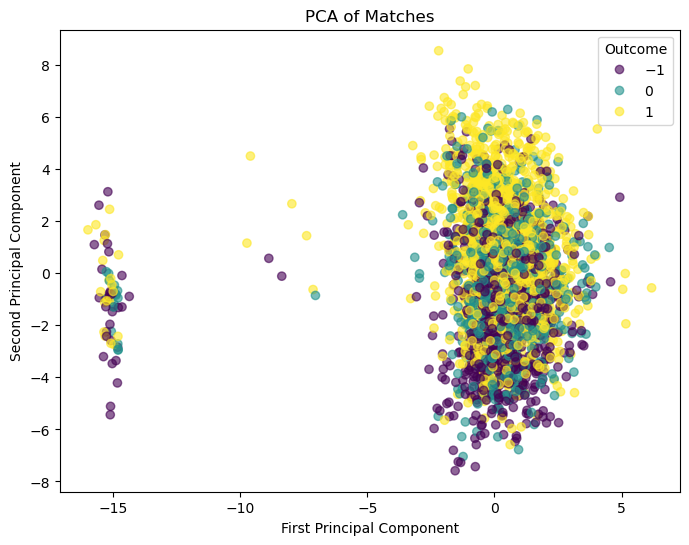

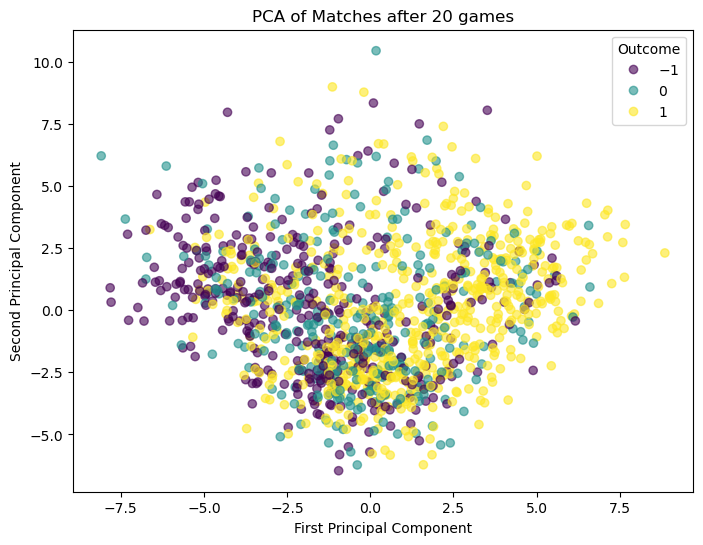

In [39]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('PCA of Matches')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()

pca20 = PCA(n_components=4)
X_train_pca20 = pca20.fit_transform(X_train_scaled20)
X_test_pca20 = pca20.transform(X_test_scaled20)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca20[:,0], X_train_pca20[:,1], c=y_train20, cmap='viridis', alpha=0.6)
plt.title('PCA of Matches after 20 games')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()


# Polynomial Transformation of Degree 2

In [6]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("Polynomial features shape:", X_train_poly.shape)

X_train_poly20 = poly.fit_transform(X_train_scaled20)
X_test_poly20 = poly.transform(X_test_scaled20)

print("Polynomial features shape:", X_train_poly20.shape)



Polynomial features shape: (2760, 779)
Polynomial features shape: (1305, 779)


# RBF Transform

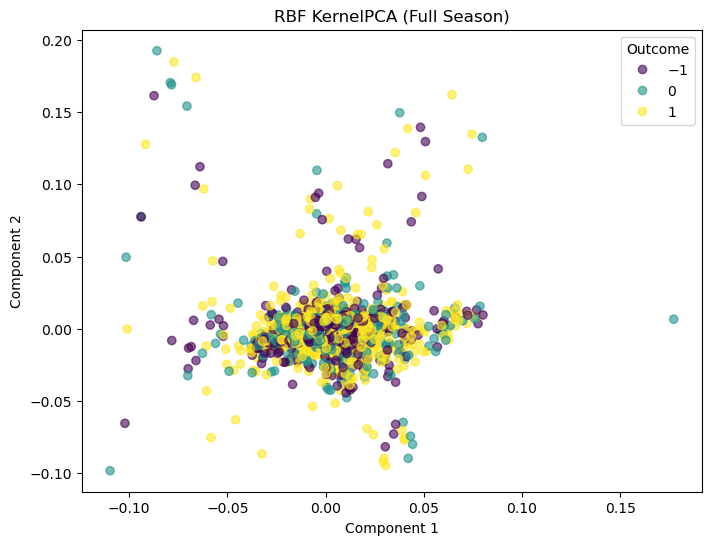

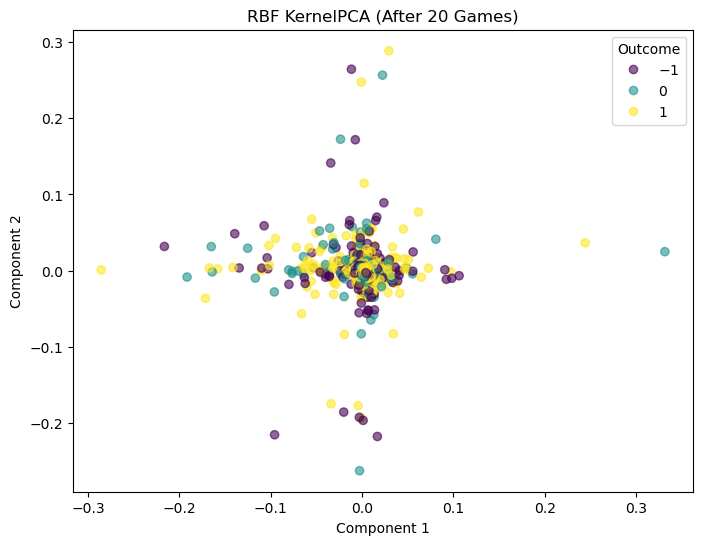

In [45]:
n_comp = 2

# Full‐season RBF Kernel PCA
kpca_rbf = KernelPCA(
    n_components=n_comp,
    kernel='rbf',
    gamma=9,
    fit_inverse_transform=False,
    random_state=42
)
X_train_kpca_rbf = kpca_rbf.fit_transform(X_train)
X_test_kpca_rbf  = kpca_rbf.transform(X_test)

# 20 games RBF Kernel PCA
kpca20_rbf = KernelPCA(
    n_components=n_comp,
    kernel='rbf',
    gamma=2,
    random_state=42
)
X_train_kpca20_rbf = kpca20_rbf.fit_transform(X_train20)
X_test_kpca20_rbf  = kpca20_rbf.transform(X_test20)


# --- Full‐season RBF KernelPCA scatter ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_kpca_rbf[:, 0],
    X_train_kpca_rbf[:, 1],
    c=y_train,
    cmap='viridis',
    alpha=0.6
)
plt.title('RBF KernelPCA (Full Season)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()

# --- “20 games” RBF KernelPCA scatter ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_kpca20_rbf[:, 0],
    X_train_kpca20_rbf[:, 1],
    c=y_train20,
    cmap='viridis',
    alpha=0.6
)
plt.title('RBF KernelPCA (After 20 Games)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()


# Logistic Regression

C=0.0001, Accuracy full: 0.5272
C=0.0001, Accuracy after 20: 0.5433
C=0.0005, Accuracy full: 0.5290
C=0.0005, Accuracy after 20: 0.5441
C=0.001, Accuracy full: 0.5264
C=0.001, Accuracy after 20: 0.5418
C=0.005, Accuracy full: 0.5203
C=0.005, Accuracy after 20: 0.5356
C=0.01, Accuracy full: 0.5152
C=0.01, Accuracy after 20: 0.5272
C=0.05, Accuracy full: 0.5123
C=0.05, Accuracy after 20: 0.5165
C=0.1, Accuracy full: 0.5120
C=0.1, Accuracy after 20: 0.5165
C=0.5, Accuracy full: 0.5112
C=0.5, Accuracy after 20: 0.5149
C=1, Accuracy full: 0.5112
C=1, Accuracy after 20: 0.5142

Best C: 0.0005, Best CV Score: 0.5290
Best C after 20 games: 0.0005, Best CV Score after 20 games: 0.5441
Test Accuracy: 0.5332
Test Accuracy after 20 games: 0.5356


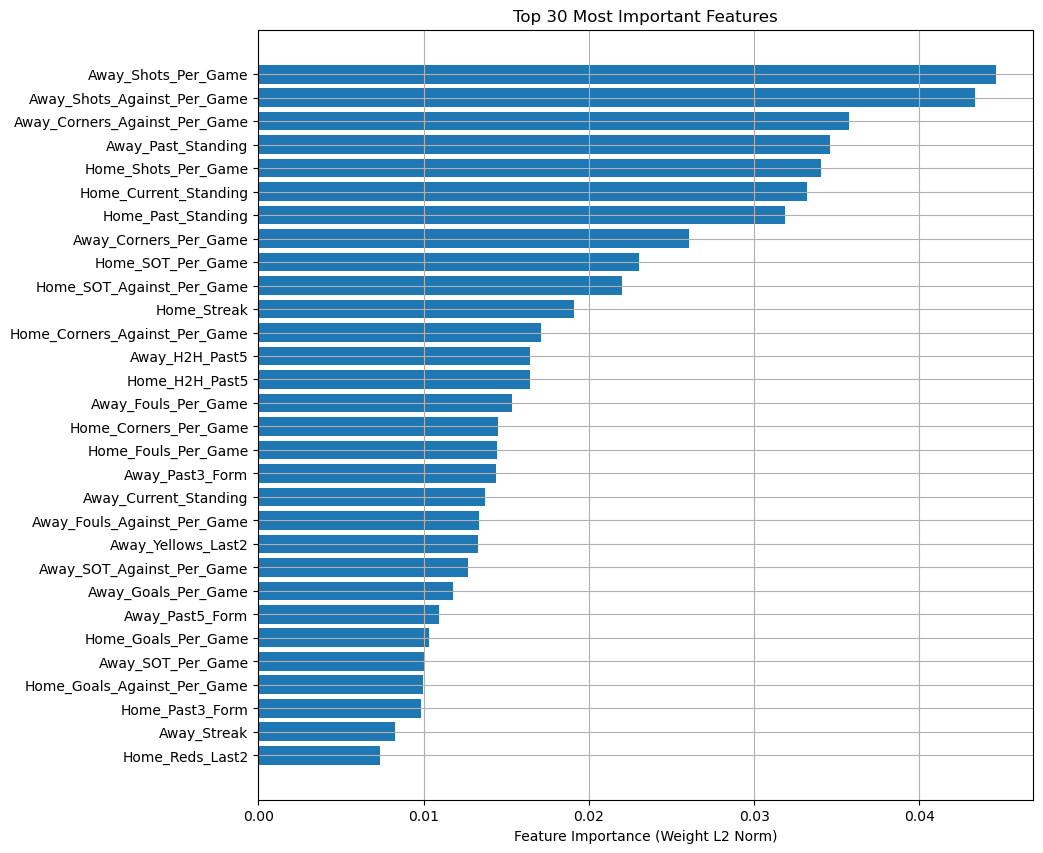

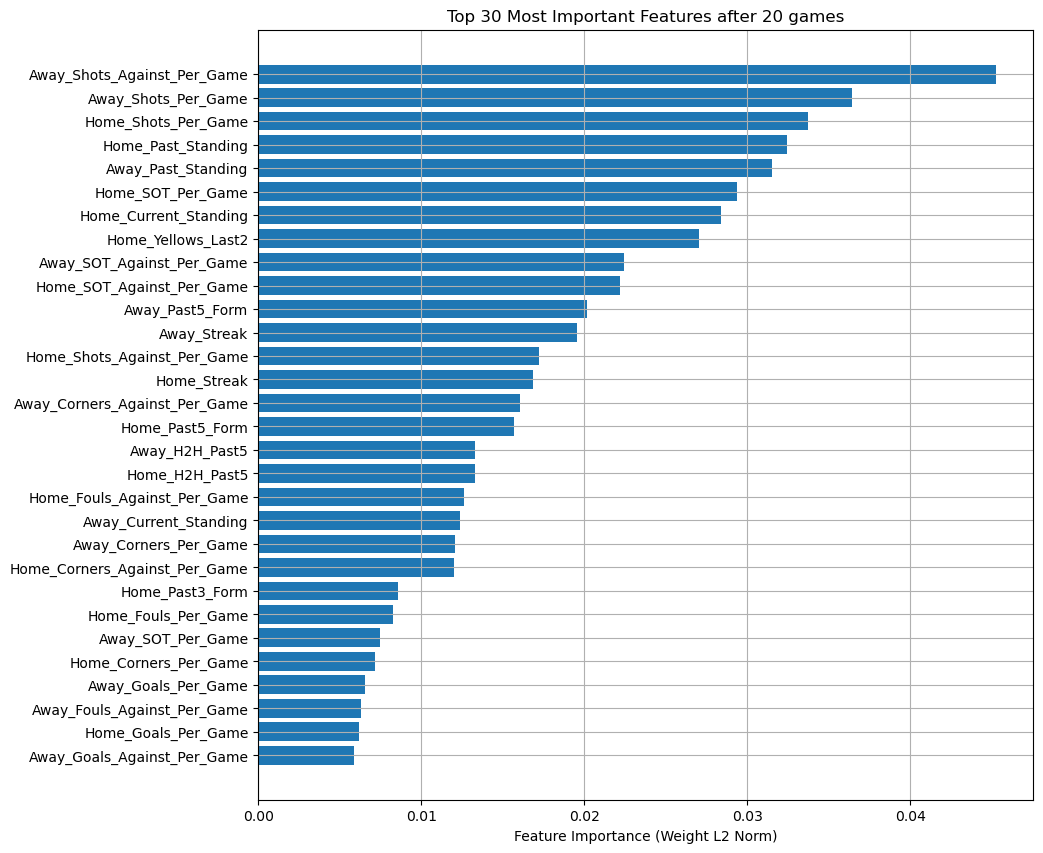

In [7]:
# Map y labels to 0, 1, 2
y_mapped = y.map({-1: 0, 0: 1, 1: 2}).astype(int)

# Cross-validation to find best C
C_values = [0.0001 , 0.0005 , 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]


best_C = None
best_score = 0

best_C20 = None
best_score20 = 0

for c in C_values:
    logreg = linear_model.LogisticRegression(
        C=c,
        penalty='l2',
        solver='lbfgs',
        max_iter=3000,
        random_state=42
    )
    
    scores = cross_val_score(logreg, X_train, y_train)
    scores20 = cross_val_score(logreg, X_train20, y_train20)
    print(f"C={c}, Accuracy full: {scores.mean():.4f}")
    print(f"C={c}, Accuracy after 20: {scores20.mean():.4f}")

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_C = c
    
    if scores20.mean() > best_score20:
        best_score20 = scores20.mean()
        best_C20 = c

print(f"\nBest C: {best_C}, Best CV Score: {best_score:.4f}")
print(f"Best C after 20 games: {best_C20}, Best CV Score after 20 games: {best_score20:.4f}")

# Train final model
best_model = linear_model.LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)

best_model20 = linear_model.LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)
best_model.fit(X_train, y_train)
best_model20.fit(X_train20, y_train20)

# Test accuracy
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test accuracy after 20 games
y_pred20 = best_model20.predict(X_test20)
test_accuracy20 = accuracy_score(y_test20, y_pred20)
print(f"Test Accuracy after 20 games: {test_accuracy20:.4f}")

feature_names = list(X.columns) 

# Get absolute weight importance
coef_matrix = best_model.coef_ 
coef_matrix20 = best_model20.coef_

# Calculate L2 norm for each feature
feature_importance = np.linalg.norm(coef_matrix, axis=0)  # shape: (number of features,)
feature_importance20 = np.linalg.norm(coef_matrix20, axis=0)  # shape: (number of features,)

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # descending
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

sorted_idx20 = np.argsort(feature_importance20)[::-1]  # descending
sorted_features20 = np.array(feature_names)[sorted_idx20]
sorted_importance20 = feature_importance20[sorted_idx20]

# Plot top N
N = 30
plt.figure(figsize=(10,10))
plt.barh(sorted_features[:N][::-1], sorted_importance[:N][::-1])
plt.xlabel('Feature Importance (Weight L2 Norm)')
plt.title(f'Top {N} Most Important Features')
plt.grid()
plt.show()

plt.figure(figsize=(10,10))
plt.barh(sorted_features20[:N][::-1], sorted_importance20[:N][::-1])
plt.xlabel('Feature Importance (Weight L2 Norm)')
plt.title(f'Top {N} Most Important Features after 20 games')
plt.grid()
plt.show()

# Logistic Regression After PCA

In [47]:
# Cross-validation to find best C for PCA-transformed data
C_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50] 
best_C_pca = None
best_score_pca = 0

best_C_pca20 = None
best_score_pca20 = 0

for c in C_values:
    logreg_pca = linear_model.LogisticRegression(
        C=c,
        penalty='l2',
        solver='lbfgs',
        max_iter=3000,
        random_state=42
    )
    scores_pca = cross_val_score(logreg_pca, X_train_pca, y_train)
    scores_pca20 = cross_val_score(logreg_pca, X_train_pca20, y_train20)
    
    
    print(f"[PCA] C={c}, Accuracy: {scores_pca.mean():.4f}")
    print(f"[PCA] C={c}, Accuracy after 20: {scores_pca20.mean():.4f}")

    if scores_pca.mean() > best_score_pca:
        best_score_pca = scores_pca.mean()
        best_C_pca = c
        
    if scores_pca20.mean() > best_score_pca20:
        best_score_pca20 = scores_pca20.mean()
        best_C_pca20 = c

print(f"\n[PCA] Best C: {best_C_pca}, Best CV Score: {best_score_pca:.4f}")
print(f"[PCA] Best C after 20 games: {best_C_pca20}, Best CV Score after 20 games: {best_score_pca20:.4f}")

# Train final model after PCA
best_model_pca = linear_model.LogisticRegression(
    C=best_C_pca,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)

best_model_pca20 = linear_model.LogisticRegression(
    C=best_C_pca20,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)

best_model_pca.fit(X_train_pca, y_train)
best_model_pca20.fit(X_train_pca20, y_train20)

# Predict and evaluate
y_pred_pca = best_model_pca.predict(X_test_pca)
test_accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"[PCA] Test Accuracy: {test_accuracy_pca:.4f}")

y_pred_pca20 = best_model_pca20.predict(X_test_pca20)
test_accuracy_pca20 = accuracy_score(y_test20, y_pred_pca20)
print(f"[PCA] Test Accuracy after 20 games: {test_accuracy_pca20:.4f}")


[PCA] C=0.001, Accuracy: 0.5112
[PCA] C=0.001, Accuracy after 20: 0.5410
[PCA] C=0.005, Accuracy: 0.5159
[PCA] C=0.005, Accuracy after 20: 0.5517
[PCA] C=0.01, Accuracy: 0.5141
[PCA] C=0.01, Accuracy after 20: 0.5510
[PCA] C=0.05, Accuracy: 0.5152
[PCA] C=0.05, Accuracy after 20: 0.5502
[PCA] C=0.1, Accuracy: 0.5156
[PCA] C=0.1, Accuracy after 20: 0.5494
[PCA] C=0.5, Accuracy: 0.5156
[PCA] C=0.5, Accuracy after 20: 0.5494
[PCA] C=1, Accuracy: 0.5152
[PCA] C=1, Accuracy after 20: 0.5494
[PCA] C=5, Accuracy: 0.5152
[PCA] C=5, Accuracy after 20: 0.5494
[PCA] C=10, Accuracy: 0.5152
[PCA] C=10, Accuracy after 20: 0.5494
[PCA] C=50, Accuracy: 0.5152
[PCA] C=50, Accuracy after 20: 0.5494

[PCA] Best C: 0.005, Best CV Score: 0.5159
[PCA] Best C after 20 games: 0.005, Best CV Score after 20 games: 0.5517
[PCA] Test Accuracy: 0.5451
[PCA] Test Accuracy after 20 games: 0.5402


# Logistic Regression After Polynomial of degree 2

In [14]:
# Cross-validation to find best C for PCA-transformed data
C_values = [0.0001, 0.001, 0.005, 0.01, 0.05] 
best_C_poly = None
best_score_poly = 0

best_C_poly20 = None
best_score_poly20 = 0

for c in C_values:
    logreg_poly = linear_model.LogisticRegression(
        C=c,
        penalty='l2',
        solver='lbfgs',
        max_iter=3000,
        random_state=42
    )
    scores_poly = cross_val_score(logreg_poly, X_train_poly, y_train)
    scores_poly20 = cross_val_score(logreg_poly, X_train_poly20, y_train20)
    print(f"[Poly] C={c}, Accuracy: {scores_poly.mean():.4f}")
    print(f"[Poly] C={c}, Accuracy after 20: {scores_poly20.mean():.4f}")

    if scores_poly.mean() > best_score_poly:
        best_score_poly = scores_poly.mean()
        best_C_poly = c
    
    if scores_poly20.mean() > best_score_poly20:
        best_score_poly20 = scores_poly20.mean()
        best_C_poly20 = c

print(f"\n[Poly] Best C: {best_C_poly}, Best CV Score: {best_score_poly:.4f}")
print(f"[Poly] Best C after 20 games: {best_C_poly20}, Best CV Score after 20 games: {best_score_poly20:.4f}")

# Train final model after PCA
best_model_poly = linear_model.LogisticRegression(
    C=best_C_poly,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)

best_model_poly20 = linear_model.LogisticRegression(
    C=best_C_poly20,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)

best_model_poly.fit(X_train_poly, y_train)

best_model_poly20.fit(X_train_poly20, y_train20)

# Predict and evaluate
y_pred_poly = best_model_poly.predict(X_test_poly)
y_pred_poly20 = best_model_poly20.predict(X_test_poly20)
test_accuracy_poly = accuracy_score(y_test, y_pred_poly)
test_accuracy_poly20 = accuracy_score(y_test20, y_pred_poly20)


print(f"[Poly] Test Accuracy: {test_accuracy_poly:.4f}")
print(f"[Poly] Test Accuracy after 20 games: {test_accuracy_poly20:.4f}")

[Poly] C=0.0001, Accuracy: 0.4928
[Poly] C=0.0001, Accuracy after 20: 0.5172
[Poly] C=0.001, Accuracy: 0.5033
[Poly] C=0.001, Accuracy after 20: 0.5211
[Poly] C=0.005, Accuracy: 0.4822
[Poly] C=0.005, Accuracy after 20: 0.4858
[Poly] C=0.01, Accuracy: 0.4728
[Poly] C=0.01, Accuracy after 20: 0.4774
[Poly] C=0.05, Accuracy: 0.4475
[Poly] C=0.05, Accuracy after 20: 0.4444

[Poly] Best C: 0.001, Best CV Score: 0.5033
[Poly] Best C after 20 games: 0.001, Best CV Score after 20 games: 0.5211
[Poly] Test Accuracy: 0.5234
[Poly] Test Accuracy after 20 games: 0.5356


# Neural Network

Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 250 of 2000
Iteration 500 of 2000
Iteration 750 of 2000
Iteration 1000 of 2000
Iteration 1250 of 2000
Iteration 1500 of 2000
Iteration 1750 of 2000


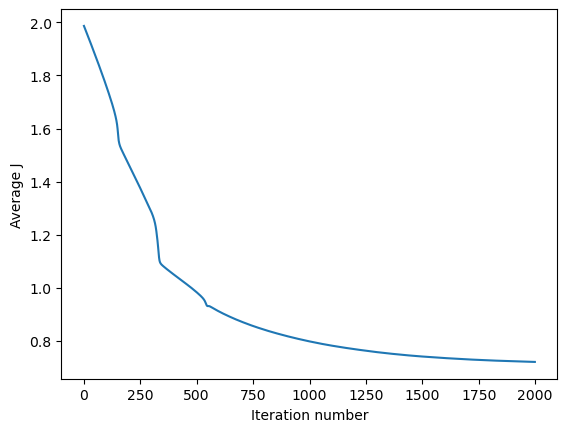

alpha = 0.2
Training accuracy is 56.24521072796935%
Prediction accuracy is 53.9080459770115%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 250 of 3000
Iteration 500 of 3000
Iteration 750 of 3000
Iteration 1000 of 3000
Iteration 1250 of 3000
Iteration 1500 of 3000
Iteration 1750 of 3000
Iteration 2000 of 3000
Iteration 2250 of 3000
Iteration 2500 of 3000
Iteration 2750 of 3000


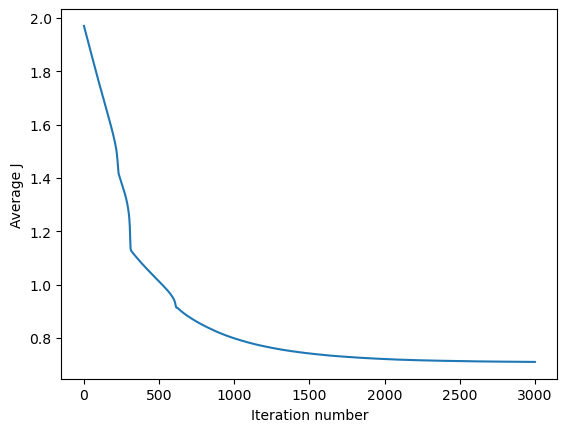

alpha = 0.2
Training accuracy is 56.85823754789272%
Prediction accuracy is 53.67816091954023%
Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 250 of 5000
Iteration 500 of 5000
Iteration 750 of 5000
Iteration 1000 of 5000
Iteration 1250 of 5000
Iteration 1500 of 5000
Iteration 1750 of 5000
Iteration 2000 of 5000
Iteration 2250 of 5000
Iteration 2500 of 5000
Iteration 2750 of 5000
Iteration 3000 of 5000
Iteration 3250 of 5000
Iteration 3500 of 5000
Iteration 3750 of 5000
Iteration 4000 of 5000
Iteration 4250 of 5000
Iteration 4500 of 5000
Iteration 4750 of 5000


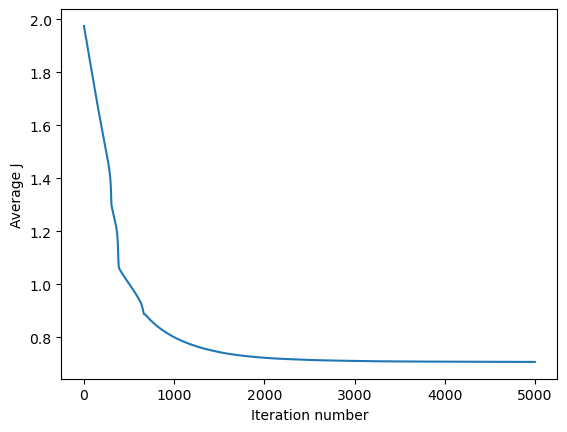

alpha = 0.2
Training accuracy is 57.39463601532567%
Prediction accuracy is 54.137931034482754%
Starting gradient descent for 10000 iterations
Iteration 0 of 10000
Iteration 250 of 10000
Iteration 500 of 10000
Iteration 750 of 10000
Iteration 1000 of 10000
Iteration 1250 of 10000
Iteration 1500 of 10000
Iteration 1750 of 10000
Iteration 2000 of 10000
Iteration 2250 of 10000
Iteration 2500 of 10000
Iteration 2750 of 10000
Iteration 3000 of 10000
Iteration 3250 of 10000
Iteration 3500 of 10000
Iteration 3750 of 10000
Iteration 4000 of 10000
Iteration 4250 of 10000
Iteration 4500 of 10000
Iteration 4750 of 10000
Iteration 5000 of 10000
Iteration 5250 of 10000
Iteration 5500 of 10000
Iteration 5750 of 10000
Iteration 6000 of 10000
Iteration 6250 of 10000
Iteration 6500 of 10000
Iteration 6750 of 10000
Iteration 7000 of 10000
Iteration 7250 of 10000
Iteration 7500 of 10000
Iteration 7750 of 10000
Iteration 8000 of 10000
Iteration 8250 of 10000
Iteration 8500 of 10000
Iteration 8750 of 10000


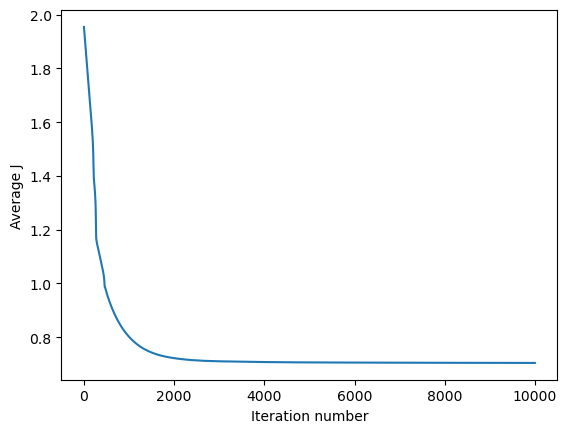

alpha = 0.2
Training accuracy is 57.8544061302682%
Prediction accuracy is 53.44827586206896%


In [ ]:

data = np.loadtxt('dataafter20.csv',delimiter=',',skiprows=1)

X = data[:, :-1].astype(float)    
y_raw = data[:,  -1].astype(int)

# 2) Remap labels from {-1,0,1} → {0,1,2}
y = y_raw + 1                      

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 3))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4)

y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)


def sig(z):
    return 1 / (1 + np.exp(-z))

def sig_deriv(z):
    return sig(z) * (1 - sig(z))

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return np.where(z > 0, 1, 0)    

def tanh(z):
    return np.tanh(z)

def tanh_deriv(z):
    return 1 - np.tanh(z)**2

def elu(z, alpha=1.0):
    return np.where(z >= 0, z, alpha * (np.exp(z) - 1))

def elu_deriv(z, alpha=1.0):
    return np.where(z >= 0, 1, elu(z, alpha) + alpha)

activation = relu
activation_deriv = relu_deriv
output = sig
output_deriv = sig_deriv

def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        if l == len(W):
            a[l+1] = output(z[l+1])   # use sigmoid only for output
        else:
            a[l+1] = activation(z[l+1]) # a^(l+1) = f(z^(l+1))

    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * output_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * activation_deriv(z_l)

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.2, lam=0.005):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))

    while cnt < iter_num:
        if cnt % 250 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))

        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0

        for i in range(N):
            delta = {}
            # Forward pass
            a, z = feed_forward(X[i, :], W, b)

            # Backward pass
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i, :], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i, :] - a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l + 1], W[l], z[l])

                    # Gradient accumulation + L2 regularization
                    tri_W[l] += np.dot(delta[l + 1][:, np.newaxis], np.transpose(a[l][:, np.newaxis])) + lam * W[l]
                    tri_b[l] += delta[l + 1]  # No regularization for biases

        # Gradient descent update
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0 / N * tri_W[l])
            b[l] += -alpha * (1.0 / N * tri_b[l])

        # Cost with L2 regularization
        avg_cost = 1.0 / N * avg_cost
        reg_term = 0.5 * lam * sum(np.sum(W[l]**2) for l in W)
        avg_cost += reg_term

        avg_cost_func.append(avg_cost)
        cnt += 1

    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

nn_structure = [38,20,3]
    
# train the NN
iters = [5000]

for l in iters:
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, l)
    # plot the avg_cost_func
    plt.plot(avg_cost_func)
    plt.ylabel('Average J')
    plt.xlabel('Iteration number')
    plt.show()

    # get the prediction accuracy and print

    y_pred = predict_y(W, b, X_test, 3)
    y_pred_train = predict_y(W, b, X_train, 3)
    print("alpha = {}".format(a))
    print('Training accuracy is {}%'.format(accuracy_score(y_train,y_pred_train) * 100))
    print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# your C grid from before
C_values = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

# 1) Linear‐kernel SVM
best_C_lin, best_score_lin = None, 0
for c in C_values:
    svm_lin = SVC(kernel='linear', C=c, random_state=42)
    scores = cross_val_score(svm_lin, X_train, y_train, cv=5)
    print(f"[Linear SVM] C={c}, CV acc = {scores.mean():.4f}")
    if scores.mean() > best_score_lin:
        best_score_lin, best_C_lin = scores.mean(), c

print(f"\nBest Linear SVM C: {best_C_lin}, CV acc = {best_score_lin:.4f}")

# train & eval on test set
svm_lin_best = SVC(kernel='linear', C=best_C_lin, random_state=42)
svm_lin_best.fit(X_train, y_train)
y_pred_lin = svm_lin_best.predict(X_test)
print("\n--- Linear SVM Test ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lin):.4f}")
print(classification_report(y_test, y_pred_lin))


# 2) RBF‐kernel SVM
best_C_rbf, best_score_rbf = None, 0
for c in C_values:
    svm_rbf = SVC(kernel='rbf', C=c, gamma='scale', random_state=42)
    scores = cross_val_score(svm_rbf, X_train, y_train, cv=5)
    print(f"[RBF SVM] C={c}, CV acc = {scores.mean():.4f}")
    if scores.mean() > best_score_rbf:
        best_score_rbf, best_C_rbf = scores.mean(), c

print(f"\nBest RBF SVM C: {best_C_rbf}, CV acc = {best_score_rbf:.4f}")

# train & eval on test set
svm_rbf_best = SVC(kernel='rbf', C=best_C_rbf, gamma='scale', random_state=42)
svm_rbf_best.fit(X_train, y_train)
y_pred_rbf = svm_rbf_best.predict(X_test)
print("\n--- RBF SVM Test ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")
print(classification_report(y_test, y_pred_rbf))

In [ ]:
y_pred = predict_y(W, b, X_test, 3)
y_pred_train = predict_y(W, b, X_train, 3)
print('Training accuracy is {}%'.format(accuracy_score(y_train,y_pred_train) * 100))
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))


Training accuracy is 54.86590038314176%
Prediction accuracy is 53.5632183908046%
